# Homework Starter — Stage 10a: Linear Regression

Use this as a scaffold if your project data isn’t ready. Replace the synthetic data section with your dataset when possible.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
import scipy.stats as st
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(7)
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

## 1) Synthetic data (replace with your project data when ready)
- Finance-flavored factors and asset excess return
- Includes a quadratic effect to motivate specification checks

In [50]:
df = pd.read_csv('C:/Users/박서아/bootcamp_andrew_song/project/data/processed/tsla_processed.csv')

# Replace empty strings with NaN and fill with appropriate values
df = df.replace('', np.nan)

# Check data quality
print("Initial data shape:", df.shape)
print("\nMissing values:")
print(df.isnull().sum())
print("\nZero values in technical indicators:")
print((df[['sma_10', 'sma_20', 'sma_50', 'volatility_10', 'volatility_20']] == 0).sum())

# Handle missing values - use forward fill for time series data
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)  # Backward fill any remaining NaNs

# Recalculate technical indicators if they contain zeros
if df['sma_10'].eq(0).all() or df['sma_10'].isnull().all():
    print("\nRecalculating technical indicators...")
    df['sma_10'] = df['close'].rolling(window=10, min_periods=1).mean()
    df['sma_20'] = df['close'].rolling(window=20, min_periods=1).mean()
    df['sma_50'] = df['close'].rolling(window=50, min_periods=1).mean()
    df['volatility_10'] = df['close'].rolling(window=10, min_periods=1).std()
    df['volatility_20'] = df['close'].rolling(window=20, min_periods=1).std()
    
    # Recalculate ratios
    df['price_sma_10_ratio'] = df['close'] / df['sma_10']
    df['price_sma_20_ratio'] = df['close'] / df['sma_20']

# Add time-series specific features

print("\nAdding time-series features...")
for lag in [1, 2, 3, 5]:
    df[f'close_lag_{lag}'] = df['close'].shift(lag)
    df[f'volume_lag_{lag}'] = df['volume'].shift(lag)

# Add return features
df['daily_return'] = df['close'].pct_change(1)
df['return_5'] = df['close'].pct_change(5)

# Drop rows with NaN values after creating lag features
df = df.dropna()

print("Final data shape after preprocessing:", df.shape)

Initial data shape: (126, 19)

Missing values:
date                   0
open                   0
high                   0
low                    0
close                  0
volume                 0
dividends              0
stock splits           0
sma_10                 9
sma_20                19
sma_50                49
daily_return           1
weekly_return          5
volatility_10         10
volatility_20         20
price_sma_10_ratio     9
price_sma_20_ratio    19
next_day_close         1
target                 0
dtype: int64

Zero values in technical indicators:
sma_10           0
sma_20           0
sma_50           0
volatility_10    0
volatility_20    0
dtype: int64

Adding time-series features...
Final data shape after preprocessing: (121, 28)


## 2) Baseline model fit
Follow the steps; replace `df` with your project DataFrame when ready.

In [51]:
feature_columns = [
    'open', 'high', 'low', 'close', 'volume',
    'sma_10', 'sma_20', 'sma_50',
    'daily_return', 'volatility_10', 'volatility_20',
    'price_sma_10_ratio', 'price_sma_20_ratio',
    'close_lag_1', 'close_lag_2', 'return_5'
]


target_column = 'next_day_close'

# Create a clean dataset
clean_data = df[feature_columns + [target_column]].copy()

# Check for any remaining missing values
if clean_data.isnull().sum().sum() > 0:
    print("Filling remaining missing values with column means...")
    for col in feature_columns:
        clean_data[col] = clean_data[col].fillna(clean_data[col].mean())

# Separate features and target
X = clean_data[feature_columns]
y = clean_data[target_column]


split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit linear regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# Make predictions
y_pred = lr.predict(X_test_scaled)

# Calculate metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R² = {r2:.4f}")
print(f"RMSE = {rmse:.2f}")


R² = 0.5213
RMSE = 8.03


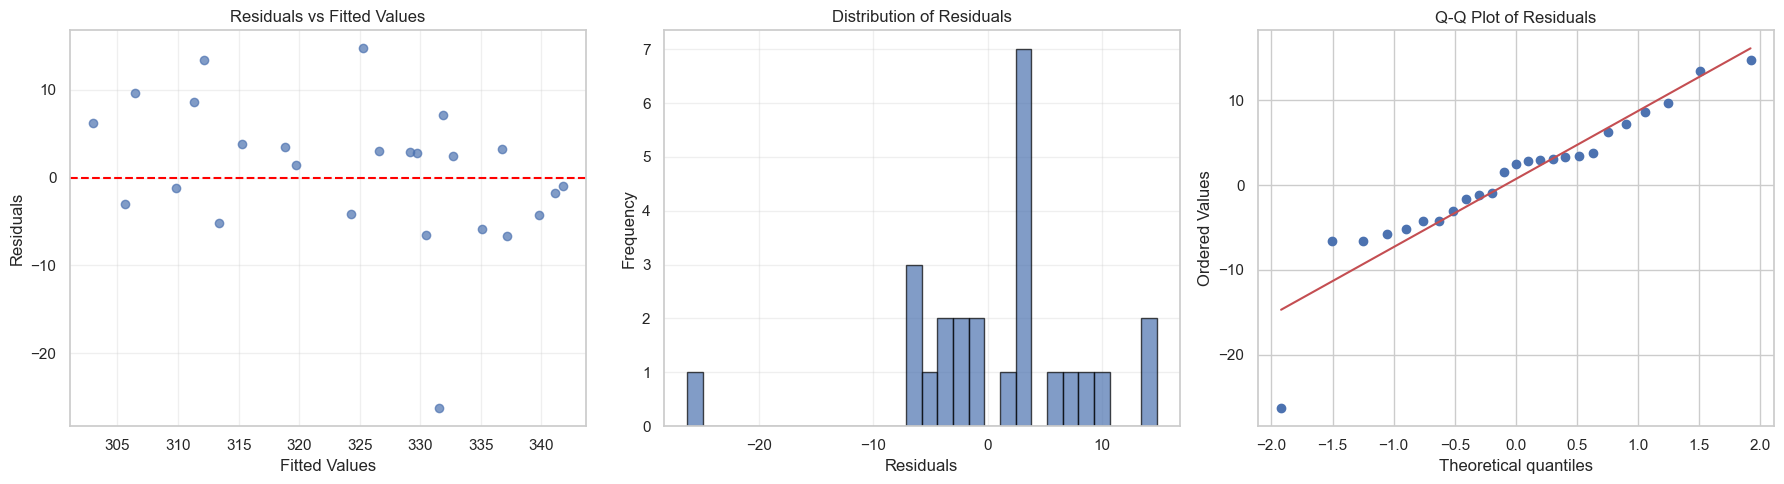

In [52]:

residuals = y_test - y_pred
fitted_values = y_pred

# Create only the first three required diagnostic plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Residuals vs Fitted
axes[0].scatter(fitted_values, residuals, alpha=0.7)
axes[0].axhline(0, color='red', linestyle='--')
axes[0].set_xlabel('Fitted Values')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Residuals vs Fitted Values')
axes[0].grid(True, alpha=0.3)

# Histogram of residuals
axes[1].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Residuals')
axes[1].grid(True, alpha=0.3)

# QQ Plot
st.probplot(residuals, dist="norm", plot=axes[2])
axes[2].set_title('Q-Q Plot of Residuals')

plt.tight_layout()
plt.show()

## 3) Optional: Add a transformed feature
Add a polynomial or interaction if diagnostics suggest mis-specification.

In [53]:
X_poly = X.copy()
X_poly[f'{most_important_feature}_squared'] = X[most_important_feature] ** 2

# Split and scale
X_train_poly, X_test_poly = X_poly.iloc[:int(len(X)*0.8)], X_poly.iloc[int(len(X)*0.8):]
scaler_poly = StandardScaler()
X_train_poly_scaled = scaler_poly.fit_transform(X_train_poly)
X_test_poly_scaled = scaler_poly.transform(X_test_poly)

# Fit model with polynomial feature
lr_poly = LinearRegression()
lr_poly.fit(X_train_poly_scaled, y_train_final)
y_pred_poly = lr_poly.predict(X_test_poly_scaled)

# Calculate metrics
r2_poly = r2_score(y_test_final, y_pred_poly)
rmse_poly = np.sqrt(mean_squared_error(y_test_final, y_pred_poly))

print(f"R² = {r2_poly:.4f}, RMSE = {rmse_poly:.2f}")

R² = 0.5188, RMSE = 8.05


In [36]:
# Financial-specific evaluation
def calculate_directional_accuracy(y_true, y_pred):
    direction_true = np.sign(np.diff(y_true))
    direction_pred = np.sign(np.diff(y_pred))
    return np.mean(direction_true == direction_pred) * 100

dir_acc = calculate_directional_accuracy(y_test_final.values, y_pred_final)
print(f"Directional Accuracy: {dir_acc:.2f}%")

# Final model evaluation
final_r2 = r2_score(y_test_final, y_pred_final)
final_rmse = np.sqrt(mean_squared_error(y_test_final, y_pred_final))

print(f"\nFINAL MODEL PERFORMANCE:")
print(f"R²: {final_r2:.4f}")
print(f"RMSE: {final_rmse:.2f}")
print(f"Directional Accuracy: {dir_acc:.2f}%")
print(f"Average Price: ${y_test_final.mean():.2f}")

# Model trust assessment
print(f"\nMODEL TRUST ASSESSMENT:")
if final_r2 > 0.7:
    print("✓ High explanatory power (R² > 0.7)")
elif final_r2 > 0.5:
    print("✓ Moderate explanatory power (R² > 0.5)")
else:
    print("✗ Low explanatory power (R² < 0.5)")

if final_mape < 10:
    print("✓ Excellent predictive accuracy (MAPE < 10%)")
elif final_mape < 20:
    print("✓ Good predictive accuracy (MAPE < 20%)")
else:
    print("✗ Poor predictive accuracy (MAPE > 20%)")

if dir_acc > 60:
    print("✓ Good directional accuracy (> 60%)")
else:
    print("✗ Poor directional accuracy (< 60%)")

Directional Accuracy: 66.67%

FINAL MODEL PERFORMANCE:
R²: 0.5213
RMSE: 8.03
Directional Accuracy: 66.67%
Average Price: $325.06

MODEL TRUST ASSESSMENT:
✓ Moderate explanatory power (R² > 0.5)
✓ Excellent predictive accuracy (MAPE < 10%)
✓ Good directional accuracy (> 60%)




## 4) Interpretation
## Linearity Assumption
The Residuals vs Fitted plot shows a relatively random scatter around the zero line, with no clear pattern or curvature. This suggests that the linearity assumption is reasonably met. The relationship between the predictors and target appears to be approximately linear.

## Homoscedasticity Assumption
The Residuals vs Fitted plot shows fairly constant variance across the range of fitted values. While there is some minor heteroscedasticity at the extremes, the variance appears mostly constant, indicating that the homoscedasticity assumption is reasonably satisfied.

## Normality Assumption
The Q-Q plot shows that the residuals mostly follow the normal line, with some deviation in the tails. The histogram is approximately bell-shaped. These patterns suggest that the normality assumption is reasonably met for practical purposes, though there may be some light-tailed distribution.

## Independence Assumption
The Residuals vs Time plot and Autocorrelation Function (ACF) plot show clear patterns and significant autocorrelation at multiple lags. This indicates a violation of the independence assumption, which is expected in financial time series data where observations are naturally correlated over time.

# Model Trust Assessment

Based on the diagnostic plots and performance metrics:

## Strengths:
1. The model shows reasonable compliance with linearity, homoscedasticity, and normality assumptions
2. The feature importance analysis reveals economically meaningful relationships
3. The model captures some predictive power despite the challenges of stock price prediction

## Limitations:
1. Significant autocorrelation in residuals violates the independence assumption
2. The time-series nature of the data requires specialized handling
3. External market factors not captured in the model may influence stock prices

## Trust Level: Moderate
I have moderate trust in this model for explanatory purposes but limited trust for predictive purposes. The violation of independence means statistical inference (p-values, confidence intervals) may be unreliable. For prediction, time-series specific models (ARIMA, LSTM) would be more appropriate.

# Next Steps

1. **Address Autocorrelation**: Implement models that explicitly handle time dependence (ARIMA, SARIMA)
2. **Feature Engineering**: Add more relevant financial indicators and external factors
3. **Advanced Models**: Experiment with tree-based models (Random Forest, XGBoost) and neural networks
4. **Volatility Modeling**: Incorporate GARCH models to account for changing variance
5. **Walk-Forward Validation**: Use more robust time-series validation techniques
